In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Configurations

In [ ]:
device='cuda'#turning the tensors of pytorch into GPU(transferring image to device GPU[image=image.to(device)])
batch_size=128#Used in trainloader,training loop()
noise_vec_dim=64#Shape of the noise vector passed into the generator Used in generator model
#Optimizers parameters
lr=0.0002#Learning Rate
beta_1=0.5#Passed in Adam Optimizer
beta_2=0.99#Passed in Adam Optimizer
#Training variables
epochs=20#How many times do we want to run our training loop

In [ ]:
#Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs=T.Compose([                            #Augmentation
                      T.RandomRotation((-20,+20)),#Rotation by -20 to +20 Degree
                      T.ToTensor()#Converts the pil or numpy image to torch tensor form
])

In [ ]:
trainset=datasets.MNIST('MNIST/',download=True,train=True,transform=train_augs)#Downloading the MNIST training Dataset and also storing it in trainset

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



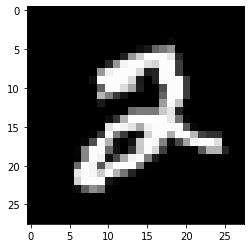

In [ ]:
image,label=trainset[5]#Viewing the image in index 5 of trainset
plt.imshow(image.squeeze(),cmap='gray')#Displaying the image using matplotlib

In [ ]:
len(trainset)#Total number of images present in trainset

60000

In [ ]:
#Load Dataset into batches meaning group them into batches each of size 128(batch size declared in configurations)

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


In [ ]:
trainloader=DataLoader(trainset,batch_size=batch_size,shuffle=True)#Shuffling the images in the trainset

In [ ]:
len(trainloader)#Total number of batches

469

In [ ]:
dataiter=iter(trainloader)

In [ ]:
images,_=dataiter.next()#No label in this thus using'_'
images.shape

torch.Size([128, 1, 28, 28])

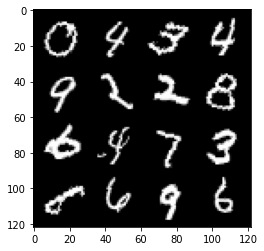

In [ ]:
tensor_img=images#Taking a batch of images to plot on a graph
num_images=16#Number of image to be plotted from a batch
size=(1,28,28)
unflat_img=tensor_img.detach().cpu()
img_grid=make_grid(unflat_img[:num_images],nrow=4)
plt.imshow(img_grid.permute(1,2,0).squeeze())
plt.show()

In [ ]:
#Creating the Discriminator Network will have three parts in each layer-convolution,batchnorm,LeakyReLU

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
def get_disc_block(in_channels,out_channels,kernel_size,stride):#Only in_channel,out_channel,kernel_size varies with each layer--Creating blocks or layers
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride),#Convolution Layer
      nn.BatchNorm2d(out_channels),#BatchNorm2d layer
      nn.LeakyReLU(0.2)#Activation Function LeakyReLU with lower limit 0.2
  )

In [ ]:
class Discriminator(nn.Module):#Creating the Discriminator Network
  def __init__(self):#Initializing the blocks/layers to be used in the Discriminator Network 
    super(Discriminator,self).__init__()
    self.block_1=get_disc_block(in_channels=1,out_channels=16,kernel_size=(3,3),stride=2)#Creating the layers
    self.block_2=get_disc_block(16,32,(5,5),2)
    self.block_3=get_disc_block(32,64,(5,5),2)
    self.flatten=nn.Flatten()
    self.linear=nn.Linear(in_features=64,out_features=1)#Bringing thr whole thing together
  def forward(self,images):#Creating the forward connections
    x1=self.block_1(images)
    x2=self.block_2(x1)
    x3=self.block_3(x2)
    x4=self.flatten(x3)
    x5=self.linear(x4)
    return x5


In [ ]:
D=Discriminator()
D.to(device)
summary(D,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
#Creating the Generative Model

In [ ]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''                        

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                               

In [ ]:
def get_gen_block(in_channels,out_channels,kernel_size,stride,final_block=False):
  if final_block==True: #A last layer which is different from the others
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
        nn.Tanh()#Activation Function
    )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
class Generator(nn.Module):#Creating the generator network
  def __init__(self,noise_vec_dim):
    super(Generator,self).__init__()
    self.noise_dim=noise_vec_dim
    self.block_1=get_gen_block(noise_vec_dim,256,(3,3),2)
    self.block_2=get_gen_block(256,128,(4,4),1)
    self.block_3=get_gen_block(128,64,(3,3),2)
    self.block_4=get_gen_block(64,1,(4,4),2,final_block=True)

  def forward(self,r_noise_vec):#Creating forward network
    x=r_noise_vec.view(-1,self.noise_dim,1,1)#Cahnging dimension/shape of input noise vector from(bs,noise_dim) to (bs,noise_dim,1,1)[bs,noise_dim,height,width]
    x1=self.block_1(x)
    x2=self.block_2(x1)
    x3=self.block_3(x2)
    x4=self.block_4(x3)
    return x4


In [ ]:
G=Generator(noise_vec_dim)
G.to(device)
summary(G,input_size=(1,noise_vec_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
def weights_init(m):#Replacing Random initialized weights to Normal weights
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
    nn.init.normal_(m.weight,0.0,0.02)
  if isinstance(m,nn.BatchNorm2d):
    nn.init.normal_(m.weight,0.0,0.02)
    nn.init.constant_(m.bias,0)  

In [ ]:
D=D.apply(weights_init)
G=G.apply(weights_init)

In [ ]:
#Creating Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):#Loss of discriminator/Generator prediction and 1 
  criterion=nn.BCEWithLogitsLoss()
  ground_truth=torch.ones_like(disc_pred)#ground truth equal to 1
  loss=criterion(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):#Loss of Discriminator/Generator prediction and 0
  criterion=nn.BCEWithLogitsLoss()
  ground_truth=torch.zeros_like(disc_pred)#ground truth equal to 0
  loss=criterion(disc_pred,ground_truth)
  return loss

In [ ]:
D_opt=torch.optim.Adam(D.parameters(),lr=lr,betas=(beta_1,beta_2))#Discriminator optimizer using Adam optimizer
G_opt=torch.optim.Adam(G.parameters(),lr=lr,betas=(beta_1,beta_2))#Generator optimizer using Adam optimizer

In [ ]:
#Training loop to train the GAN Model

In [ ]:
from tqdm import tqdm#For creating a progress bar to track the progress of the loops

In [ ]:
for i in range(epochs):#Running loop for epochs times
  total_d_loss=0.0#Setting total Discriminator loss to 0.0
  total_g_loss=0.0#Setting total Generator loss to 0.0
  for real_img,_ in tqdm(trainloader):#Taking real image from trainloader with no label so _ | tqdm to track the progress of the loop
    real_img=real_img.to(device)
    noise=torch.randn(batch_size,noise_vec_dim,device=device)#Taking random noise from torch with shape (batch_size=128,noise_dim=64) and with devie=device

    #Finding loss and update weights of Discriminator and thus train it in the process
    D_opt.zero_grad()#Optimizing the Discriminator with zero gradient
    fake_img=G(noise)#Generating the fake image by passing the noise from torch to Generator network
    D_pred=D(fake_img)#Getting the prediction from Discriminator for a fake image generated from Generator
    D_fake_loss=fake_loss(D_pred)#Calculating the Discriminator loss for its prediction with the fake image
    D_pred=D(real_img)#Getting prediction from discriminator for a real image
    D_real_loss=real_loss(D_pred)#Calculating the Discriminator loss for its prediction when a real image is passed to the Discriminator
    D_loss=(D_fake_loss+D_real_loss)/2#Finding average of the two losses to get a final Discriminator loss
    total_d_loss=total_d_loss+D_loss.item()#Updating the total Discriminator loss
    D_loss.backward(retain_graph=True)#Changing the gradient
    D_opt.step()#Updating the weights of the Discriminator

    #Finding loss and update weights for Generator and thus training it in the process
    G_opt.zero_grad()#Optimizing the Generator with zero gradient
    noise=torch.randn(batch_size,noise_vec_dim,device=device)#Generating random noise with torch
    fake_image=G(noise)#Generating a fake image from the noise by passing it to the Generator 
    D_pred=D(fake_img)#Getting Discriminator prediction by passing the fake image
    G_loss=real_loss(D_pred)#Here only doing real loss because we want the Generator to produce realistic images thus calculatin glos witht he real side which is 1
    total_g_loss=total_g_loss+G_loss.item()#Updating the total Generator loss
    G_loss.backward(retain_graph=True)#Changing the gradient
    G_opt.step()#Updating the weights of the Generator
  avg_d_loss=total_d_loss/len(trainloader)#Calculating average loss by dividing Discriminator total loss by number of images in trainloader which is 60000
  avg_g_loss=total_g_loss/len(trainloader)#Calculating average loss by dividing Generator total loss by number of images in trainloader which is 60000
  print("Epoch:{} | D_loss:{} | G_loss:{}".format(i+1,avg_d_loss,avg_g_loss)) 
  #show_tensor_images(fake_img)#Printing the fake image generated by Generator

100%|██████████| 469/469 [00:16<00:00, 28.98it/s]


Epoch:1 | D_loss:0.6472378030006312 | G_loss:0.8461555919921728


100%|██████████| 469/469 [00:16<00:00, 29.19it/s]


Epoch:2 | D_loss:0.6486781708467235 | G_loss:0.8425948182657075


 35%|███▍      | 164/469 [00:05<00:10, 29.37it/s]